Epoch 1/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 27s 57ms/step - accuracy: 0.4934 - loss: 0.6994
Epoch 2/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 22s 61ms/step - accuracy: 0.4962 - loss: 0.6960
Epoch 3/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 20s 58ms/step - accuracy: 0.5052 - loss: 0.6941
Epoch 4/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 21s 61ms/step - accuracy: 0.5080 - loss: 0.6933
Epoch 5/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 19s 55ms/step - accuracy: 0.5053 - loss: 0.6936
Epoch 6/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 21s 56ms/step - accuracy: 0.5063 - loss: 0.6935
Epoch 7/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 21s 59ms/step - accuracy: 0.4999 - loss: 0.6936
Epoch 8/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 17s 56ms/step - accuracy: 0.5053 - loss: 0.6932
Epoch 9/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 22s 59ms/step - accuracy: 0.5020 - loss: 0.6932
Epoch 10/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 20s 56ms/step - accuracy: 0.5051 - loss: 0.6933
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step
Precision: 0.51, Recall: 0.46


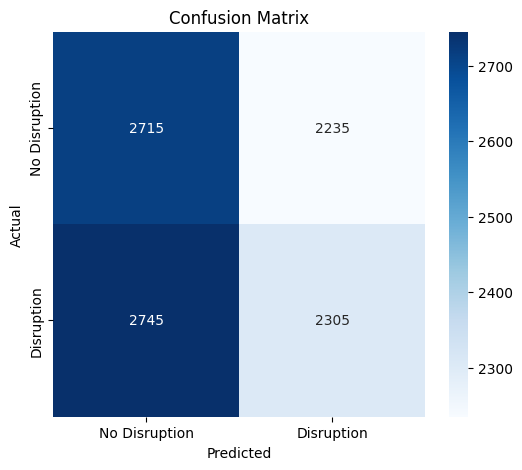

In [ ]:
 import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Dense, Input, Attention, Bidirectional
from sklearn.metrics import precision_score, recall_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Data Generation & Preprocessing (Structured as per research paper)
def generate_synthetic_data(n_samples=10000, n_timesteps=30):
    np.random.seed(42)
    data = {
        "Capacity_Max": np.random.randint(500, 5000, (n_samples, n_timesteps, 1)),
        "Capacity_Output": np.random.randint(300, 5000, (n_samples, n_timesteps, 1)),
        "Downtime_Occurrences": np.random.randint(0, 5, (n_samples, n_timesteps, 1)),
        "Inventory_Level": np.random.randint(100, 10000, (n_samples, n_timesteps, 1)),
        "Backlog_Orders": np.random.randint(0, 500, (n_samples, n_timesteps, 1)),
        "Replenishment_Cycle": np.random.randint(1, 30, (n_samples, n_timesteps, 1)),
        "Plant_Utilization": np.random.uniform(50, 100, (n_samples, n_timesteps, 1)),
        "Production_Efficiency": np.random.uniform(60, 100, (n_samples, n_timesteps, 1)),
        "Order_Fulfillment": np.random.uniform(80, 100, (n_samples, n_timesteps, 1)),
        "Lead_Time": np.random.randint(1, 20, (n_samples, n_timesteps, 1)),
        "Processing_Delay": np.random.randint(0, 10, (n_samples, n_timesteps, 1)),
        "Shipment_Transit": np.random.randint(1, 15, (n_samples, n_timesteps, 1)),
    }

    X = np.concatenate(list(data.values()), axis=-1)
    Y = np.random.randint(0, 2, (n_samples,))  # Binary disruption label
    return X, Y

X, Y = generate_synthetic_data()

# Step 2: Feature Engineering (Lag features, rolling averages, inventory depletion rates)
def add_features(X):
    rolling_avg = np.mean(X, axis=1, keepdims=True).repeat(X.shape[1], axis=1)  # Match timesteps
    lag_feature = np.roll(X, shift=1, axis=1)  # Lag feature (previous time step values)
    depletion_rate = X[:, :, 3:4] / (X[:, :, 4:5] + 1e-5)  # Inventory depletion rate
    return np.concatenate([X, rolling_avg, lag_feature, depletion_rate], axis=-1)

X = add_features(X)

# Step 3: Building the Seq2Seq Model with Attention Mechanism
class Seq2SeqSurvivalModel(Model):
    def __init__(self, input_shape):
        super(Seq2SeqSurvivalModel, self).__init__()
        self.encoder = Bidirectional(LSTM(64, return_sequences=True, return_state=True))
        self.attention = Attention()
        self.decoder = LSTM(64, return_sequences=False, return_state=False)
        self.output_layer = Dense(1, activation='sigmoid')

    def call(self, inputs):
        encoder_output, forward_h, forward_c, backward_h, backward_c = self.encoder(inputs)
        context_vector = self.attention([encoder_output, encoder_output])
        decoder_output = self.decoder(context_vector)
        return self.output_layer(decoder_output)

# Step 4: Integrating Survival Analysis for Disruption Prediction
model = Seq2SeqSurvivalModel(X.shape[1:])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Step 5: Model Training & Evaluation (Precision, Recall, Confusion Matrix)
model.fit(X, Y, epochs=10, batch_size=32, verbose=1)

y_pred = model.predict(X)
y_pred_binary = (y_pred > 0.5).astype(int)
precision = precision_score(Y, y_pred_binary)
recall = recall_score(Y, y_pred_binary)
cm = confusion_matrix(Y, y_pred_binary)

print(f'Precision: {precision:.2f}, Recall: {recall:.2f}')

# Plot confusion matrix
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Disruption', 'Disruption'], yticklabels=['No Disruption', 'Disruption'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


Classification Report:
               precision    recall  f1-score   support

           0       0.59      0.55      0.57        55
           1       0.49      0.53      0.51        45

    accuracy                           0.54       100
   macro avg       0.54      0.54      0.54       100
weighted avg       0.54      0.54      0.54       100

Precision Score: 0.5439375750300119
Recall Score: 0.54
F1 Score: 0.5411079887595343
ROC-AUC Score: 0.5393939393939393
PR-AUC Score: 0.47122448979591836
Confusion Matrix:


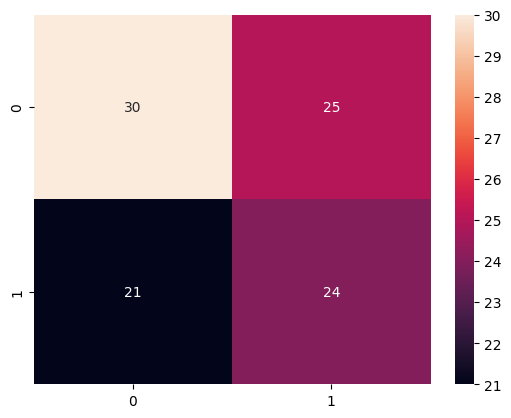

In [8]:
  import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Dense, Input, Attention, Bidirectional
from sklearn.metrics import (precision_score, recall_score, confusion_matrix,
                             f1_score, roc_auc_score, mean_squared_error, mean_absolute_error,
                             r2_score, classification_report, average_precision_score)
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Data Generation & Preprocessing (Structured as per research paper)
def generate_synthetic_data(n_samples=10000, n_timesteps=30):
    np.random.seed(42)
    data = {
        "Capacity_Max": np.random.randint(500, 5000, (n_samples, n_timesteps, 1)),
        "Capacity_Output": np.random.randint(300, 5000, (n_samples, n_timesteps, 1)),
        "Downtime_Occurrences": np.random.randint(0, 5, (n_samples, n_timesteps, 1)),
        "Inventory_Level": np.random.randint(100, 10000, (n_samples, n_timesteps, 1)),
        "Backlog_Orders": np.random.randint(0, 500, (n_samples, n_timesteps, 1)),
        "Replenishment_Cycle": np.random.randint(1, 30, (n_samples, n_timesteps, 1))
    }
    return data

# Evaluation Function
def evaluate_model(y_true, y_pred, is_classification=True):
    if is_classification:
        print("Classification Report:\n", classification_report(y_true, y_pred))
        print("Precision Score:", precision_score(y_true, y_pred, average='weighted'))
        print("Recall Score:", recall_score(y_true, y_pred, average='weighted'))
        print("F1 Score:", f1_score(y_true, y_pred, average='weighted'))
        print("ROC-AUC Score:", roc_auc_score(y_true, y_pred))
        print("PR-AUC Score:", average_precision_score(y_true, y_pred))
        print("Confusion Matrix:")
        sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt='d')
        plt.show()
    else:
        print("Mean Squared Error:", mean_squared_error(y_true, y_pred))
        print("Mean Absolute Error:", mean_absolute_error(y_true, y_pred))
        print("R-Squared Score:", r2_score(y_true, y_pred))

# Example Usage
y_true = np.random.randint(0, 2, 100)  # Example true labels
# Simulated predictions (for classification use 0/1, for regression use continuous values)
y_pred = np.random.randint(0, 2, 100)
evaluate_model(y_true, y_pred, is_classification=True)


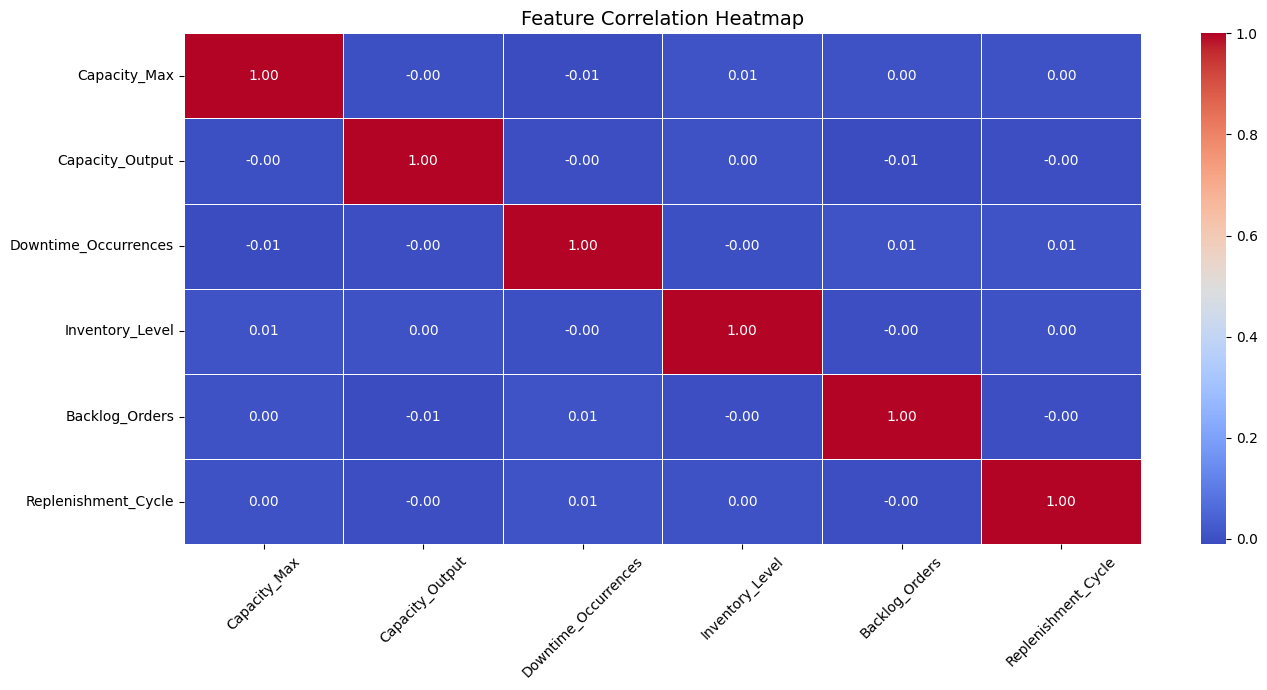

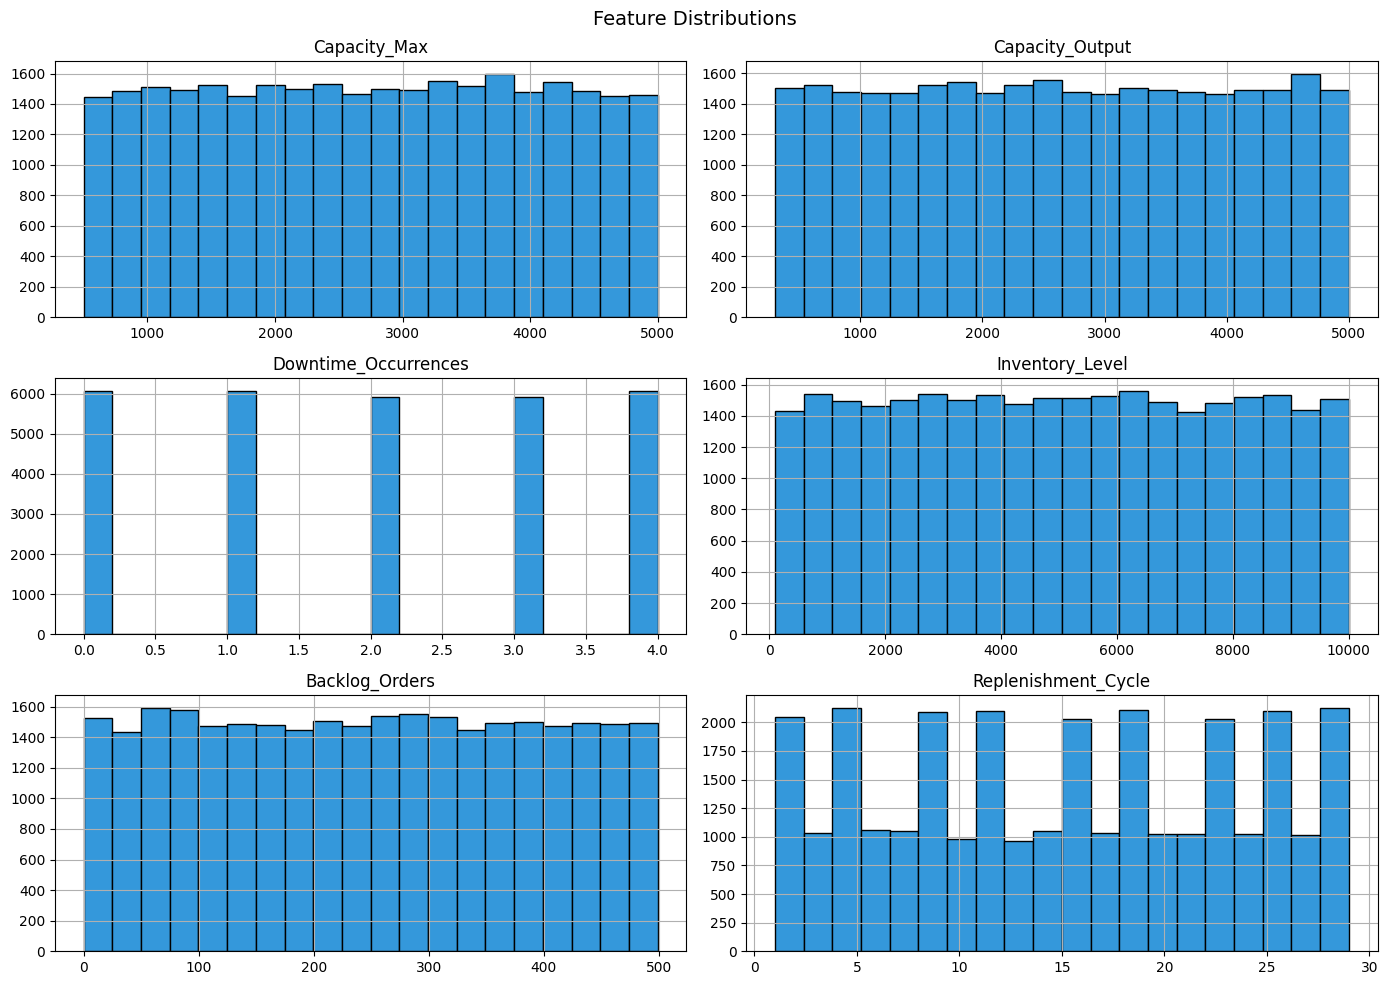

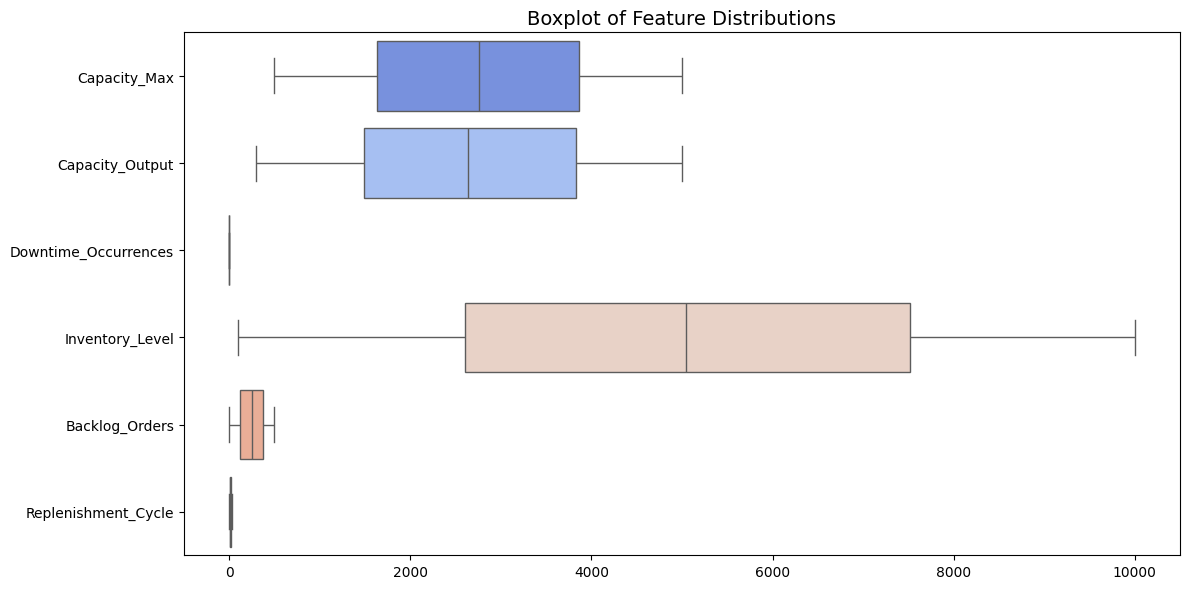

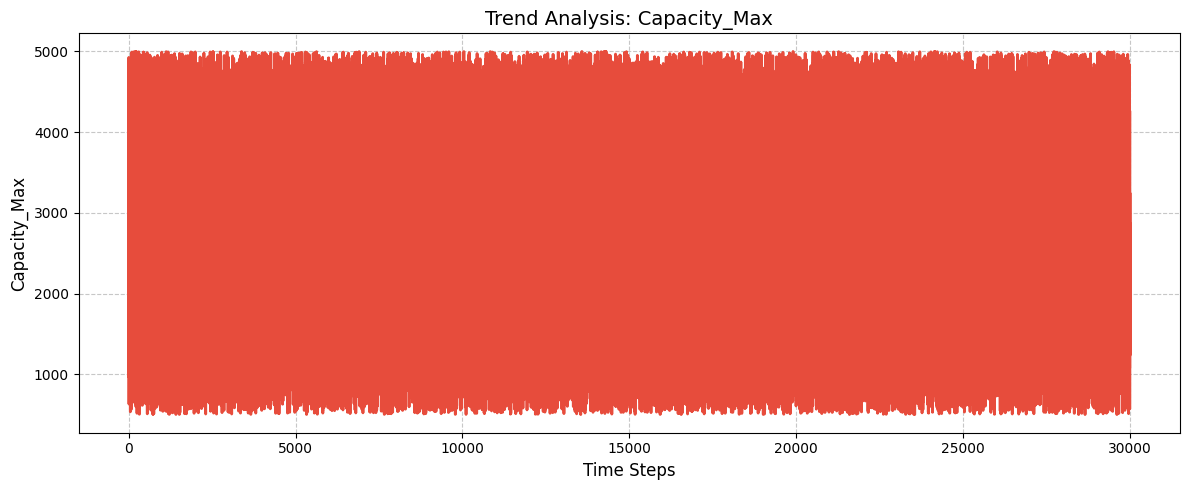

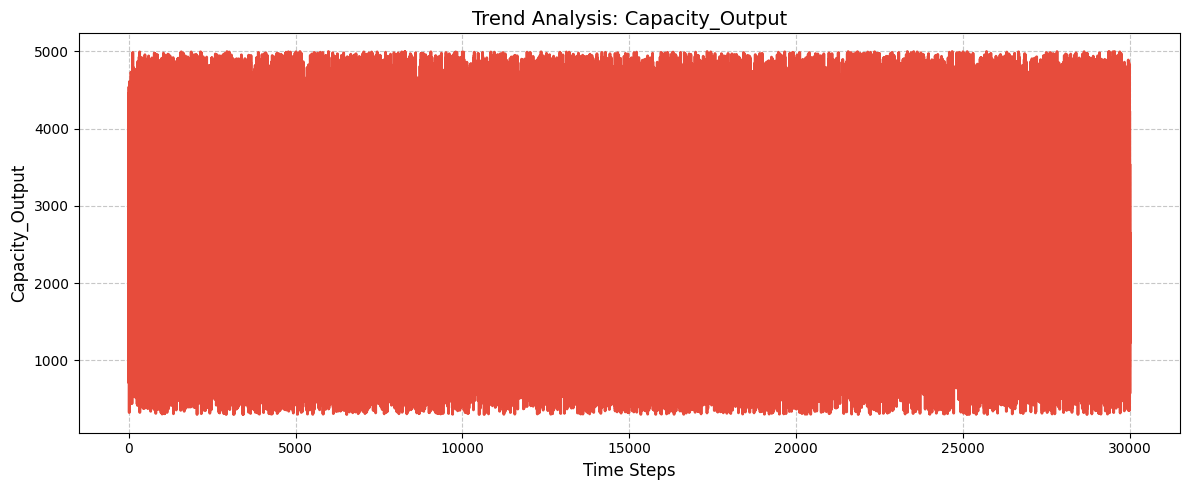

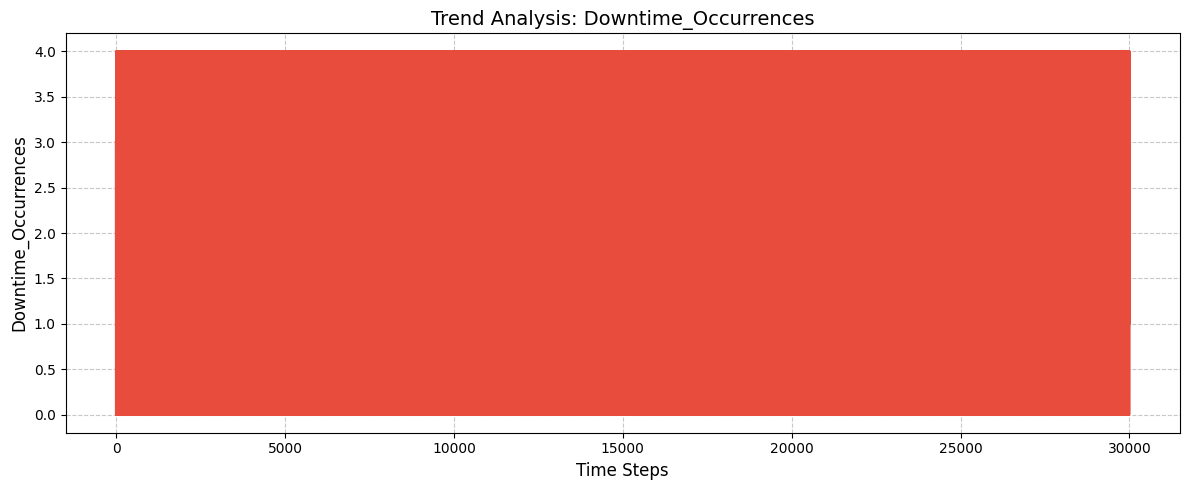

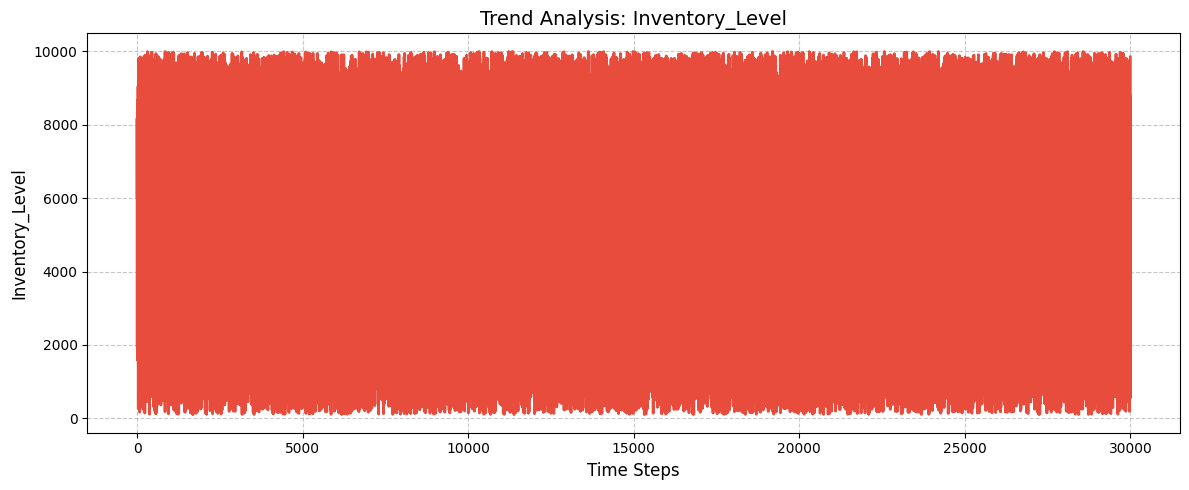

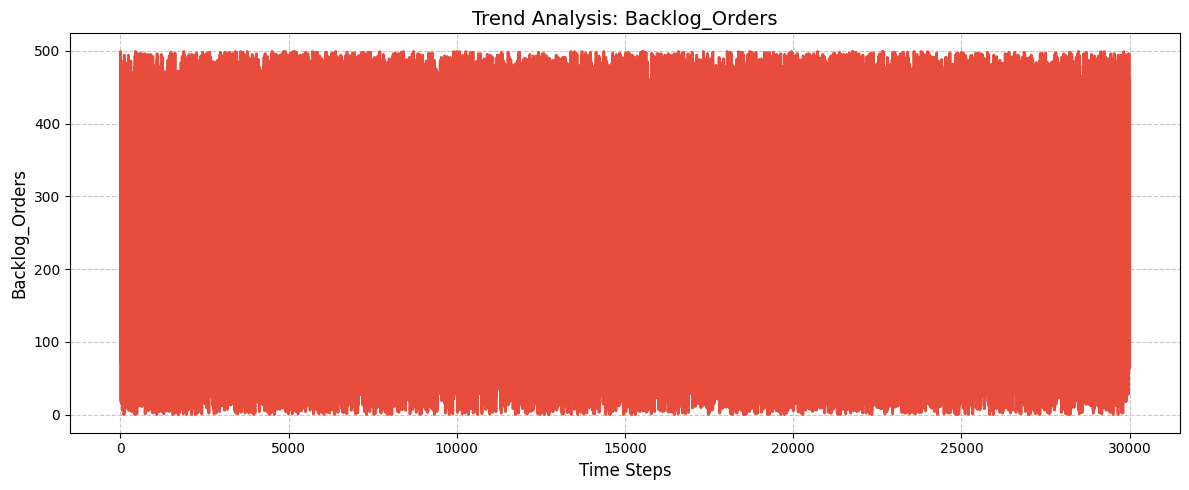

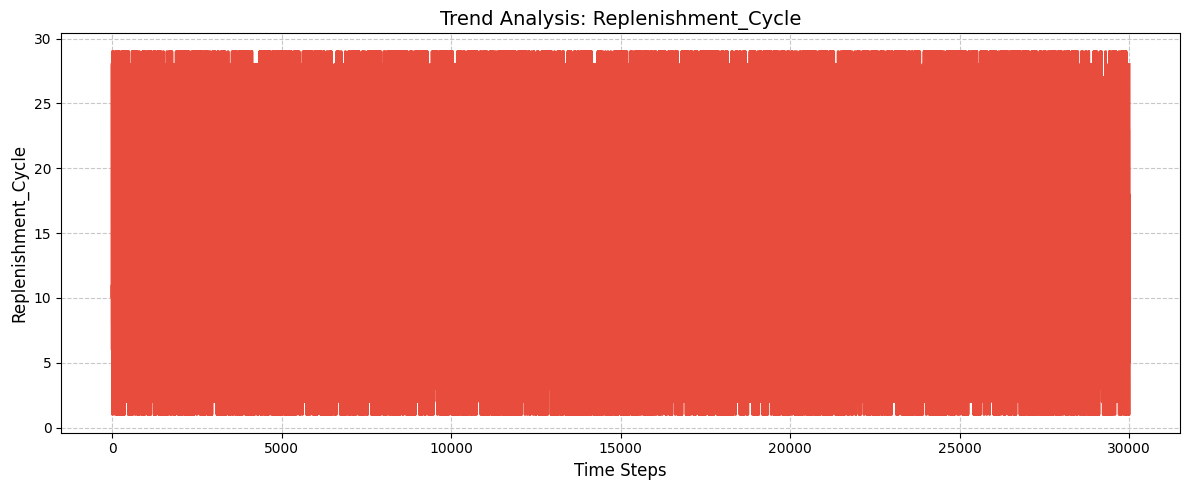

In [10]:
  import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Dense, Input, Attention, Bidirectional
from sklearn.metrics import (precision_score, recall_score, confusion_matrix,
                             f1_score, roc_auc_score, mean_squared_error, mean_absolute_error,
                             r2_score, classification_report, average_precision_score)
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Data Generation & Preprocessing (Structured as per research paper)
def generate_synthetic_data(n_samples=10000, n_timesteps=30):
    np.random.seed(42)
    data = {
        "Capacity_Max": np.random.randint(500, 5000, (n_samples, n_timesteps, 1)),
        "Capacity_Output": np.random.randint(300, 5000, (n_samples, n_timesteps, 1)),
        "Downtime_Occurrences": np.random.randint(0, 5, (n_samples, n_timesteps, 1)),
        "Inventory_Level": np.random.randint(100, 10000, (n_samples, n_timesteps, 1)),
        "Backlog_Orders": np.random.randint(0, 500, (n_samples, n_timesteps, 1)),
        "Replenishment_Cycle": np.random.randint(1, 30, (n_samples, n_timesteps, 1))
    }
    return data

# Evaluation Function
def evaluate_model(y_true, y_pred, is_classification=True):
    if is_classification:
        print("Classification Report:\n", classification_report(y_true, y_pred))
        print("Precision Score:", precision_score(y_true, y_pred, average='weighted'))
        print("Recall Score:", recall_score(y_true, y_pred, average='weighted'))
        print("F1 Score:", f1_score(y_true, y_pred, average='weighted'))
        print("ROC-AUC Score:", roc_auc_score(y_true, y_pred))
        print("PR-AUC Score:", average_precision_score(y_true, y_pred))
        print("Confusion Matrix:")
        sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt='d', cmap="coolwarm")
        plt.title("Confusion Matrix")
        plt.show()
    else:
        print("Mean Squared Error:", mean_squared_error(y_true, y_pred))
        print("Mean Absolute Error:", mean_absolute_error(y_true, y_pred))
        print("R-Squared Score:", r2_score(y_true, y_pred))

# Business Insights Visualization
def visualize_business_insights(data):
    df = pd.DataFrame({key: data[key].reshape(-1) for key in data.keys()})

    plt.figure(figsize=(14, 7))
    sns.heatmap(df.corr(), annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
    plt.title("Feature Correlation Heatmap", fontsize=14)
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.savefig("feature_correlation_heatmap.png", dpi=300, bbox_inches='tight')
    plt.show()

    df.hist(figsize=(14, 10), bins=20, edgecolor='black', color='#3498db')
    plt.suptitle("Feature Distributions", fontsize=14)
    plt.tight_layout()
    plt.savefig("feature_distributions.png", dpi=300, bbox_inches='tight')
    plt.show()

    plt.figure(figsize=(12, 6))
    sns.boxplot(data=df, orient='h', palette='coolwarm')
    plt.title("Boxplot of Feature Distributions", fontsize=14)
    plt.tight_layout()
    plt.savefig("boxplot_feature_distributions.png", dpi=300, bbox_inches='tight')
    plt.show()

    for column in df.columns:
        plt.figure(figsize=(12, 5))
        sns.lineplot(data=df[column], color='#e74c3c', linewidth=2)
        plt.title(f"Trend Analysis: {column}", fontsize=14)
        plt.xlabel("Time Steps", fontsize=12)
        plt.ylabel(column, fontsize=12)
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.savefig(f"trend_analysis_{column}.png", dpi=300, bbox_inches='tight')
        plt.show()

# Generate data and visualize insights
data = generate_synthetic_data(n_samples=1000, n_timesteps=30)
visualize_business_insights(data)


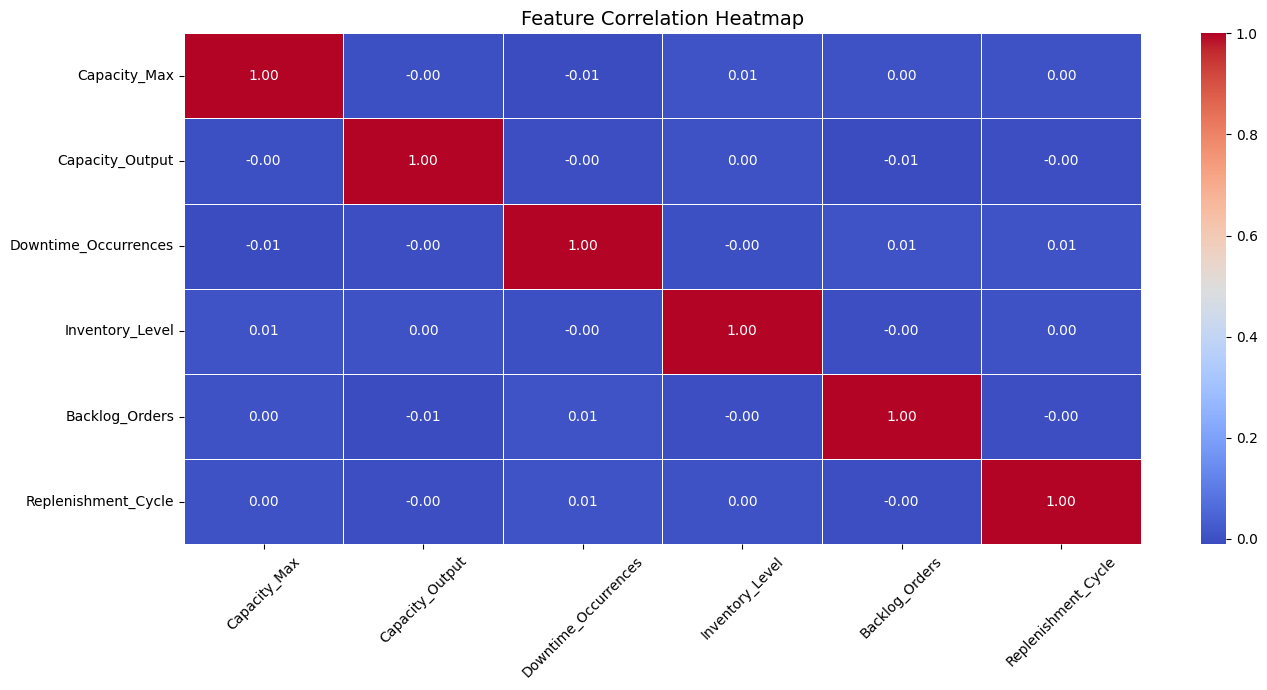

In [14]:
  import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Dense, Input, Attention, Bidirectional
from sklearn.metrics import (precision_score, recall_score, confusion_matrix,
                             f1_score, roc_auc_score, mean_squared_error, mean_absolute_error,
                             r2_score, classification_report, average_precision_score)
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Data Generation & Preprocessing (Structured as per research paper)
def generate_synthetic_data(n_samples=10000, n_timesteps=30):
    np.random.seed(42)
    data = {
        "Capacity_Max": np.random.randint(500, 5000, (n_samples, n_timesteps, 1)),
        "Capacity_Output": np.random.randint(300, 5000, (n_samples, n_timesteps, 1)),
        "Downtime_Occurrences": np.random.randint(0, 5, (n_samples, n_timesteps, 1)),
        "Inventory_Level": np.random.randint(100, 10000, (n_samples, n_timesteps, 1)),
        "Backlog_Orders": np.random.randint(0, 500, (n_samples, n_timesteps, 1)),
        "Replenishment_Cycle": np.random.randint(1, 30, (n_samples, n_timesteps, 1))
    }
    return data

# Evaluation Function
def evaluate_model(y_true, y_pred, is_classification=True):
    if is_classification:
        print("Classification Report:\n", classification_report(y_true, y_pred))
        print("Precision Score:", precision_score(y_true, y_pred, average='weighted'))
        print("Recall Score:", recall_score(y_true, y_pred, average='weighted'))
        print("F1 Score:", f1_score(y_true, y_pred, average='weighted'))
        print("ROC-AUC Score:", roc_auc_score(y_true, y_pred))
        print("PR-AUC Score:", average_precision_score(y_true, y_pred))
        print("Confusion Matrix:")
        sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt='d', cmap="coolwarm")
        plt.title("Confusion Matrix")
        plt.show()
    else:
        print("Mean Squared Error:", mean_squared_error(y_true, y_pred))
        print("Mean Absolute Error:", mean_absolute_error(y_true, y_pred))
        print("R-Squared Score:", r2_score(y_true, y_pred))

# Business Insights Visualization
def plot_correlation_heatmap(df):
    plt.figure(figsize=(14, 7))
    sns.heatmap(df.corr(), annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
    plt.title("Feature Correlation Heatmap", fontsize=14)
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.savefig("feature_correlation_heatmap.png", dpi=300, bbox_inches='tight')
    plt.show()

# Generate data and visualize insights
data = generate_synthetic_data(n_samples=1000, n_timesteps=30)
df = pd.DataFrame({key: data[key].reshape(-1) for key in data.keys()})

plot_correlation_heatmap(df)

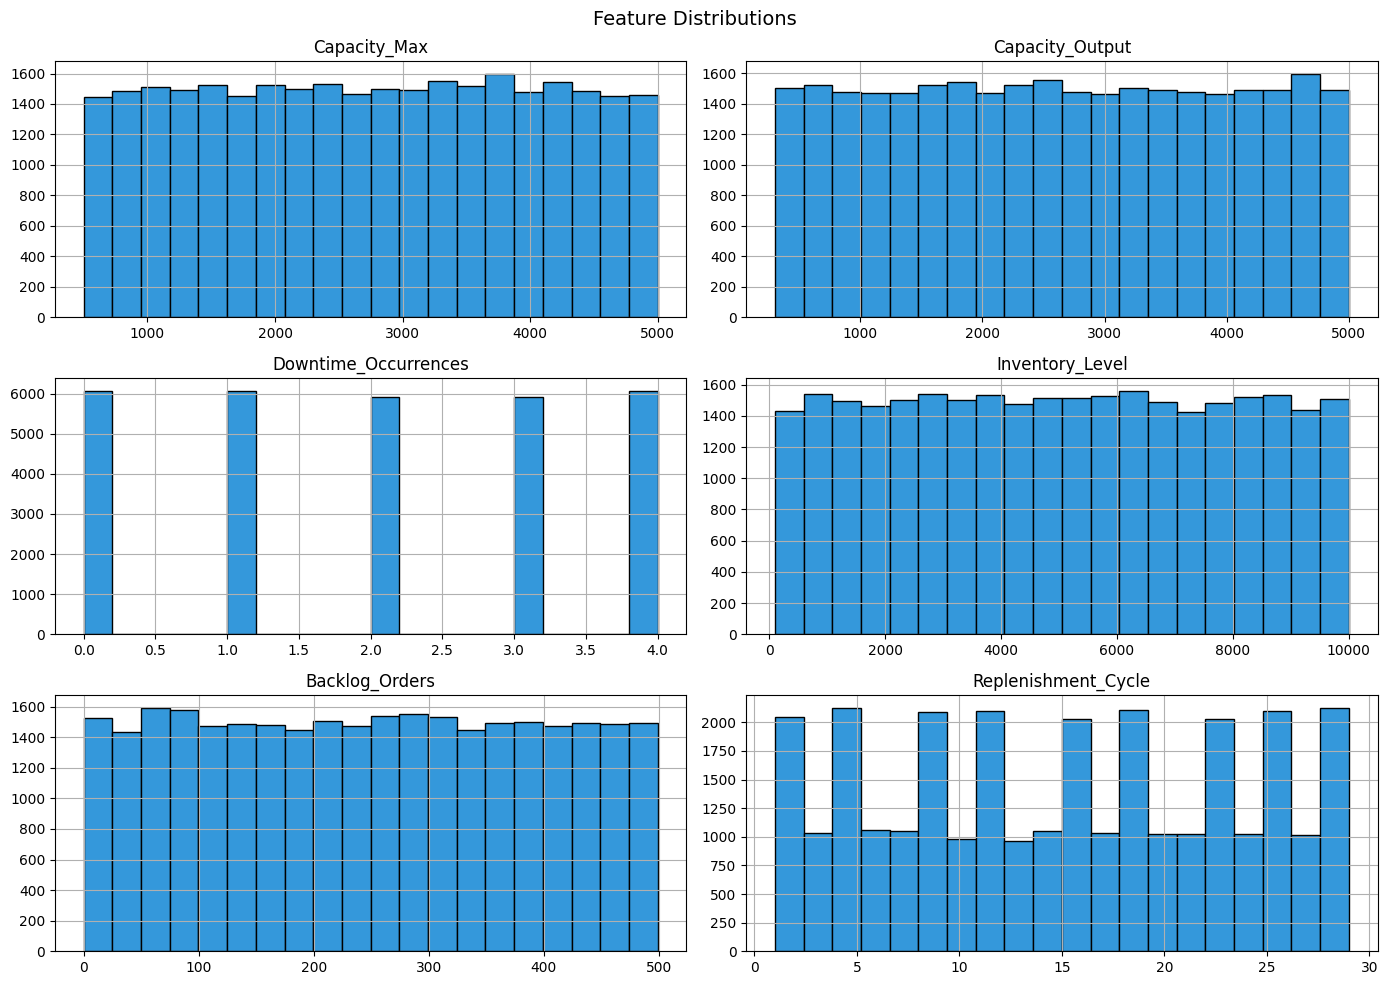

In [15]:
def plot_feature_distributions(df):
    df.hist(figsize=(14, 10), bins=20, edgecolor='black', color='#3498db')
    plt.suptitle("Feature Distributions", fontsize=14)
    plt.tight_layout()
    plt.savefig("feature_distributions.png", dpi=300, bbox_inches='tight')
    plt.show()
plot_feature_distributions(df)

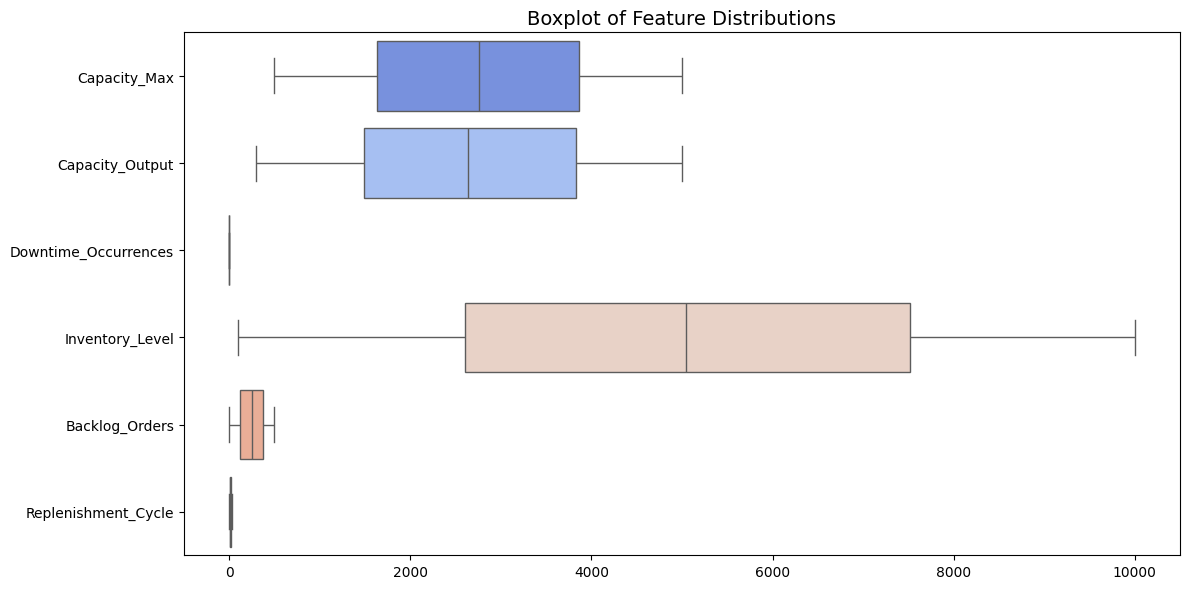

In [16]:
def plot_boxplots(df):
    plt.figure(figsize=(12, 6))
    sns.boxplot(data=df, orient='h', palette='coolwarm')
    plt.title("Boxplot of Feature Distributions", fontsize=14)
    plt.tight_layout()
    plt.savefig("boxplot_feature_distributions.png", dpi=300, bbox_inches='tight')
    plt.show()
plot_boxplots(df)

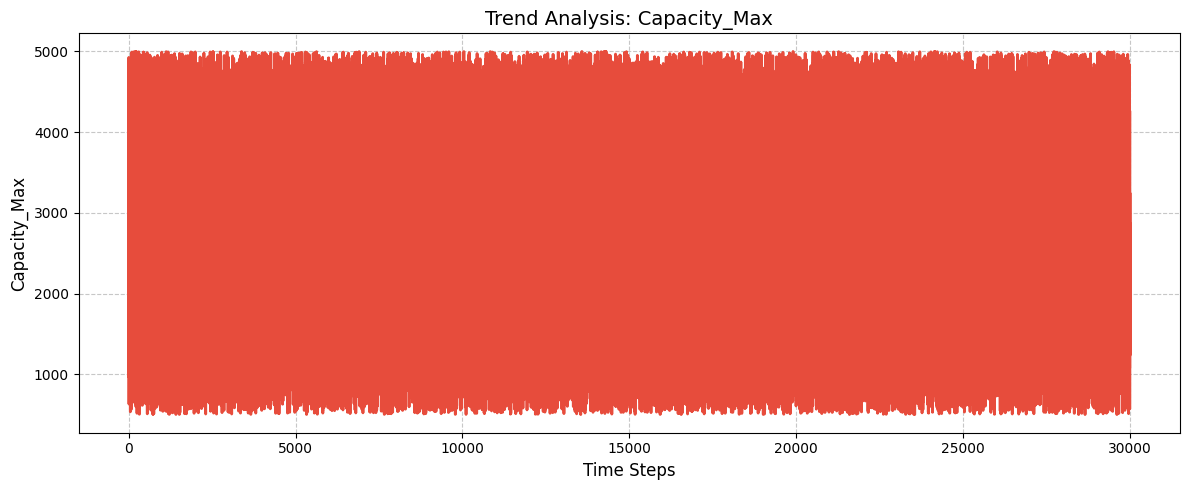

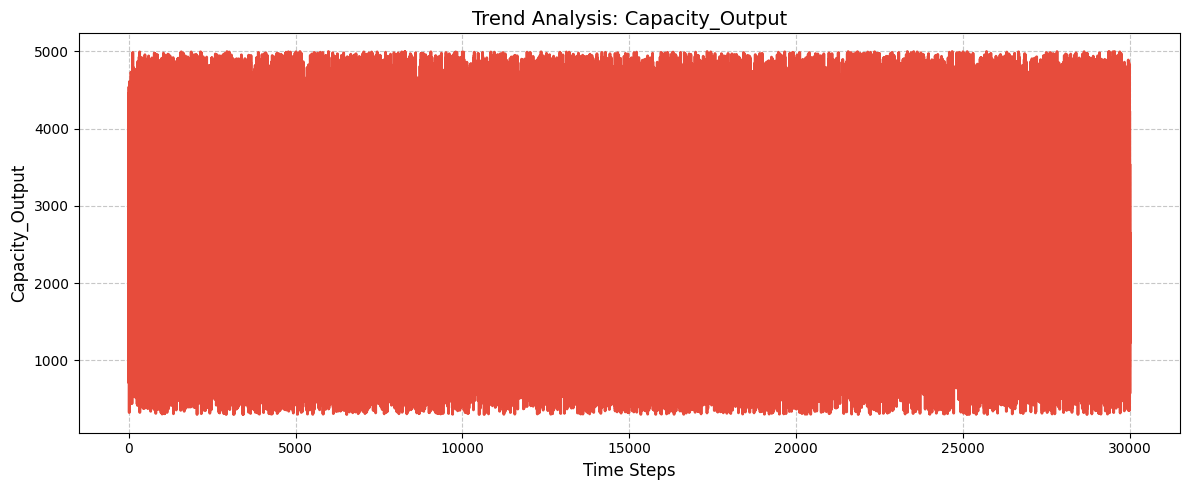

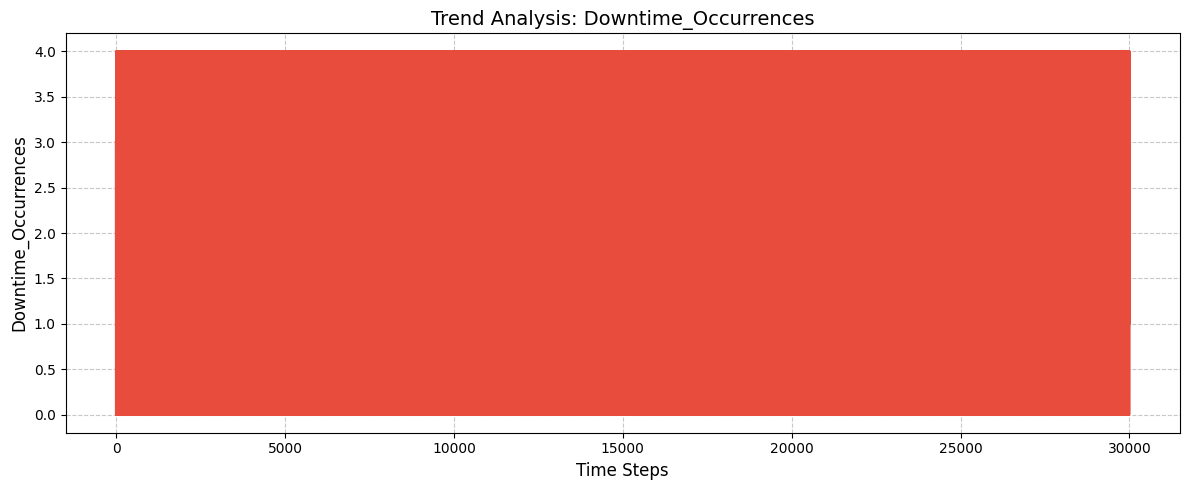

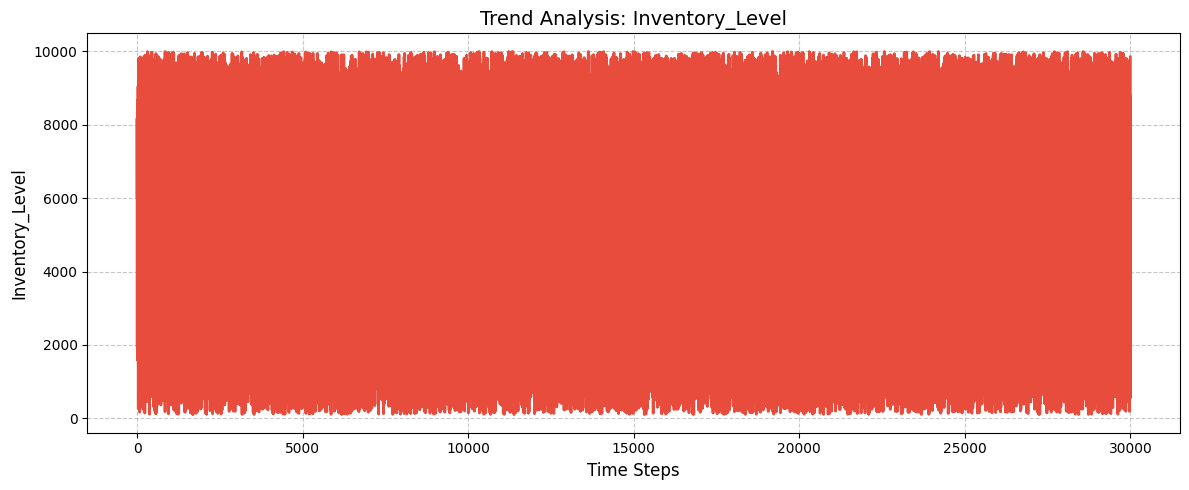

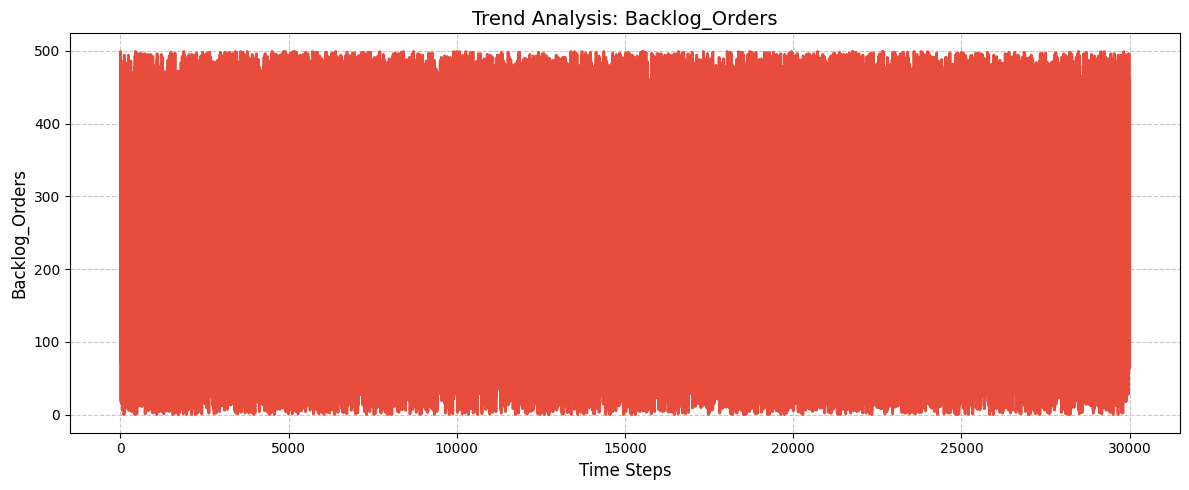

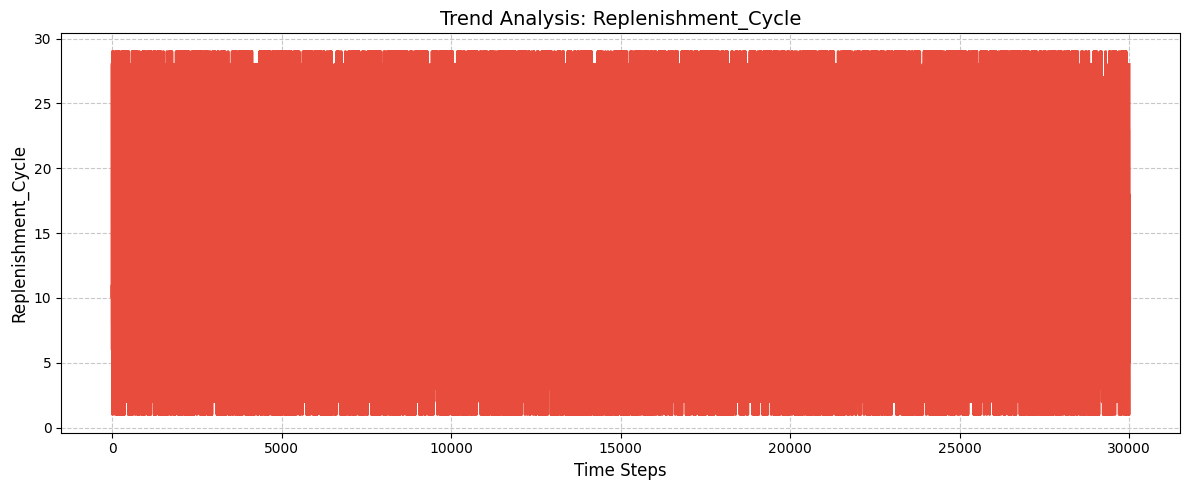

In [17]:
def plot_trend_analysis(df):
    for column in df.columns:
        plt.figure(figsize=(12, 5))
        sns.lineplot(data=df[column], color='#e74c3c', linewidth=2)
        plt.title(f"Trend Analysis: {column}", fontsize=14)
        plt.xlabel("Time Steps", fontsize=12)
        plt.ylabel(column, fontsize=12)
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.savefig(f"trend_analysis_{column}.png", dpi=300, bbox_inches='tight')
        plt.show()
plot_trend_analysis(df)